# Notebook with RF on Energy Label as target variable with unfiltered BAG on apartment level (which gives 6464 green roofs for random forest)

In [4]:
!pip install geopandas pyproj shapely fiona


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import warnings
import joblib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    GridSearchCV,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    VotingClassifier
)
from sklearn.utils import resample

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')

In [ ]:
# This data file is not included in the repository due to size constraints
# Replace the path below with your own local copy to run the notebook
gdf = gpd.read_file('path/to/GR_unfiltered_energy_all_address.gpkg')

## Data checks

In [10]:
print(len(gdf))

459224


**Gebruiksdoel**


Exploration of gebruiksdoel which are gonna link to different types of energy labels




In [12]:
unique_values = gdf['gebruiksdoel'].unique()
print(unique_values)

['woonfunctie' 'logiesfunctie'
 'industriefunctie,winkelfunctie,woonfunctie' 'kantoorfunctie,woonfunctie'
 'bijeenkomstfunctie,onderwijsfunctie' 'bijeenkomstfunctie,sportfunctie'
 'bijeenkomstfunctie,kantoorfunctie,woonfunctie'
 'onderwijsfunctie,sportfunctie'
 'onderwijsfunctie,overige gebruiksfunctie' 'onderwijsfunctie' None
 'bijeenkomstfunctie' 'winkelfunctie,woonfunctie'
 'industriefunctie,kantoorfunctie,overige gebruiksfunctie,winkelfunctie,woonfunctie'
 'bijeenkomstfunctie,industriefunctie,woonfunctie'
 'industriefunctie,overige gebruiksfunctie,woonfunctie'
 'gezondheidszorgfunctie,kantoorfunctie,onderwijsfunctie,overige gebruiksfunctie,woonfunctie'
 'bijeenkomstfunctie,overige gebruiksfunctie,woonfunctie' 'kantoorfunctie'
 'overige gebruiksfunctie,sportfunctie,woonfunctie'
 'industriefunctie,overige gebruiksfunctie'
 'kantoorfunctie,overige gebruiksfunctie,woonfunctie'
 'bijeenkomstfunctie,industriefunctie,kantoorfunctie,onderwijsfunctie,overige gebruiksfunctie,winkelfunctie,wo

In [13]:
#unique combinations?
unique_combinations = gdf['gebruiksdoel'].dropna().unique()

#split all combinations into individual words and flatten the list
all_words = [item.strip() for combo in unique_combinations for item in combo.split(',')]

#get the unique individual words
unique_words = sorted(set(all_words))

#display the result
print(unique_words)


['bijeenkomstfunctie', 'celfunctie', 'gezondheidszorgfunctie', 'industriefunctie', 'kantoorfunctie', 'logiesfunctie', 'onderwijsfunctie', 'overige gebruiksfunctie', 'sportfunctie', 'winkelfunctie', 'woonfunctie']


In [14]:
print(gdf['gebruiksdoel'].value_counts().sort_index())

missing_values = gdf['gebruiksdoel'].isna().sum()
print(f"Missing values in 'gebruiksdoel': {missing_values}")

gebruiksdoel
bijeenkomstfunctie                                                                                                               1111
bijeenkomstfunctie,celfunctie,industriefunctie,kantoorfunctie,overige gebruiksfunctie,sportfunctie                                  1
bijeenkomstfunctie,celfunctie,sportfunctie,winkelfunctie,woonfunctie                                                              291
bijeenkomstfunctie,gezondheidszorgfunctie                                                                                          11
bijeenkomstfunctie,gezondheidszorgfunctie,industriefunctie,kantoorfunctie,overige gebruiksfunctie,winkelfunctie,woonfunctie       151
                                                                                                                                ...  
sportfunctie,winkelfunctie,woonfunctie                                                                                             95
sportfunctie,woonfunctie                         

**Energy label**

In [16]:
print(gdf['Energielabel'].value_counts().sort_index())

missing_values = gdf['Energielabel'].isna().sum()
print(f"Missing values in 'Energielabel': {missing_values}")

Energielabel
A         117279
A+         17865
A++         9433
A+++        4096
A++++        624
A+++++        32
B          52066
C          77271
D          42691
E          21274
F          10432
G          12088
Name: count, dtype: int64
Missing values in 'Energielabel': 94073


**Already Green Roof**

In [18]:
print(gdf['already_GR'].value_counts().sort_index())

already_GR
0    452616
1      6608
Name: count, dtype: int64


**Insulated Roof**

Create a variable that indicated wheather a roof is insulated or not. Above (an including) C roofs are insulated

In [20]:
def classify_roof_insulation(label):
    if pd.isna(label):
        return np.nan
    elif label.upper() in ['A+++++','A++++', 'A+++', 'A++','A+', 'A', 'B', 'C']:
        return 1
    elif label.upper() in ['D', 'E', 'F', 'G']:
        return 0
    else:
        return np.nan

#apply the function to create the new column
gdf['Roof_insulation'] = gdf['Energielabel'].apply(classify_roof_insulation)

print(gdf[['Energielabel', 'Roof_insulation']].head())


  Energielabel  Roof_insulation
0         None              NaN
1         None              NaN
2         None              NaN
3         None              NaN
4            A              1.0


In [21]:
print(gdf['Roof_insulation'].value_counts(dropna=False))

Roof_insulation
1.0    278666
NaN     94073
0.0     86485
Name: count, dtype: int64


# ENERGY CLASSIFICATION from RVO

In [ ]:
# Load energy label data from RVO
df = pd.read_csv('data/Energy_Labels.csv')

df.head()

,Letter of Lettercombinatie,Woning,Kantoor,Bijeenkomst zonder kinderdagverblijf,Bijeenkomst met kinderdagverblijf,Onderwijs,Zorg zonder bed,Zorg met bed,Winkel,Sport,Logies,Cel
0,A+++++,NaN,"Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00","Kleiner of gelijk aan 0,00"
1,A++++,"Kleiner of gelijk aan 0,00","0,01 t/m 40,00","0,01 t/m 50,00","0,01 t/m 55,00","0,01 t/m 50,00","0,01 t/m 45,00","0,01 t/m 90,00","0,01 t/m 60,00","0,01 t/m 35,00","0,01 t/m 50,00","0,01 t/m 60,00"
2,A+++,"0,01 t/m 50,00","40,01 t/m 80,00","50,01 t/m 100,00","55,01 t/m 110,00","50,01 t/m 100,00","45,01 t/m 90,00","90,01 t/m 180,00","60,01 t/m 120,00","35,01 t/m 70,00","50,01 t/m 100,00","60,01 t/m 120,00"
3,A++,"50,01 t/m 75,00","80,01 t/m 120,00","100,01 t/m 150,00","110,01 t/m 165,00","100,01 t/m 150,00","90,01 t/m 135,00","180,01 t/m 270,00","120,01 t/m 180,00","70,01 t/m 105,00","100,01 t/m 150,00","120,01 t/m 180,00"
4,A+,"75,01 t/m 105,00","120,01 t/m 160,00","150,01 t/m 200,00","165,01 t/m 220,00","150,01 t/m 200,00","135,01 t/m 180,00","270,01 t/m 360,00","180,01 t/m 240,00","105,01 t/m 140,00","150,01 t/m 200,00","180,01 t/m 240,00"


In [24]:
#making the excel table into a panda data frame
#clean column names
df.columns = [col.strip() for col in df.columns]

#reshape from wide to long format
long_df = df.melt(
    id_vars=['Letter of Lettercombinatie'],
    var_name='Building_Type',
    value_name='Consumption_Range'
)

# Function to parse the consumption range strings
def parse_range(cell):
    cell = str(cell).strip()
    if "t/m" in cell:
        low, high = cell.split("t/m")
        return float(low.replace(",", ".")), float(high.replace(",", "."))
    elif "Kleiner of gelijk aan" in cell:
        value = float(cell.split("aan")[1].strip().replace(",", "."))
        return float('-inf'), value
    elif "Groter dan" in cell:
        value = float(cell.split("dan")[1].strip().replace(",", "."))
        return value, float('inf')
    elif cell == 'N/A' or pd.isna(cell):
        return None, None
    else:
        return None, None

#apply the parsing function
long_df[['Min_Consumption', 'Max_Consumption']] = long_df['Consumption_Range'].apply(parse_range).apply(pd.Series)

#rename for clarity
long_df.rename(columns={'Letter of Lettercombinatie': 'Label'}, inplace=True)

#custom mean
def custom_mean(row):
    if row['Label'] == 'A++++' and row['Building_Type'] == 'Woning':
        return 0.0
    elif row['Label'] == 'A+++++' and row['Building_Type'] != 'Woning':
        return row['Max_Consumption']
    elif row['Label'] == 'G':
        return row['Min_Consumption']
    else:
        # Default: average if both values exist
        if pd.notnull(row['Min_Consumption']) and pd.notnull(row['Max_Consumption']):
            return (row['Min_Consumption'] + row['Max_Consumption']) / 2
        else:
            return np.nan

long_df['Mean_Consumption'] = long_df.apply(custom_mean, axis=1)

long_df.head(100)

,Label,Building_Type,Consumption_Range,Min_Consumption,Max_Consumption,Mean_Consumption
0,A+++++,Woning,NaN,NaN,NaN,NaN
1,A++++,Woning,"Kleiner of gelijk aan 0,00",-inf,0.0,0.000
2,A+++,Woning,"0,01 t/m 50,00",0.01,50.0,25.005
3,A++,Woning,"50,01 t/m 75,00",50.01,75.0,62.505
4,A+,Woning,"75,01 t/m 105,00",75.01,105.0,90.005
...,...,...,...,...,...,...
95,G,Winkel,"Groter dan 475,00",475.00,inf,475.000
96,A+++++,Sport,"Kleiner of gelijk aan 0,00",-inf,0.0,0.000
97,A++++,Sport,"0,01 t/m 35,00",0.01,35.0,17.505
98,A+++,Sport,"35,01 t/m 70,00",35.01,70.0,52.505


**Format energy classification and building purpose to get mean consumption**

In [26]:
#a.define restrictiveness order (lower is more restrictive)
rvo_restrictiveness = {
    'woning': 1,
    'cel': 2,
    'kantoor': 3,
    'onderwijs': 4,
    'logies': 5,
    'sport': 6,
    'winkel': 7,
    'zorg zonder bed': 8,
    'zorg met bed': 8,
    'bijeenkomst zonder kinderdagverblijf': 9,
    'bijeenkomst met kinderdagverblijf': 9
}

#since woning is most restictive
# Fill missing 'gebruiksdoel' with 'woning'
gdf['gebruiksdoel'] = gdf['gebruiksdoel'].fillna('woonfunctie')

# Optional: Confirm the update
print("Missing values in 'gebruiksdoel' after fill:", gdf['gebruiksdoel'].isna().sum())


#b.map my dataset's `gebruiksdoel` to RVO
gebruiksdoel_to_rvo = {
    'woonfunctie': ['woning'],
    'woning': ['woning'],
    'winkelfunctie': ['winkel'],
    'sportfunctie': ['sport'],
    'overige gebruiksfunctie': ['bijeenkomst zonder kinderdagverblijf'],
    'onderwijsfunctie': ['onderwijs'],
    'logiesfunctie': ['logies'],
    'kantoorfunctie': ['kantoor'],
    'industriefunctie': ['bijeenkomst zonder kinderdagverblijf'],
    'gezondheidszorgfunctie': ['zorg zonder bed', 'zorg met bed'],
    'celfunctie': ['cel'],
    'bijeenkomstfunctie': ['bijeenkomst zonder kinderdagverblijf', 'bijeenkomst met kinderdagverblijf']
}

#c.define function to get most restrictive mapped use
def get_most_restrictive_use(entry, label):
    if pd.isna(entry):
        return np.nan
    categories = [x.strip() for x in entry.split(',')]
    rvo_equivalents = []
    for cat in categories:
        mapped = gebruiksdoel_to_rvo.get(cat, [])
        rvo_equivalents.extend(mapped)

    if not rvo_equivalents:
        return np.nan

    rvo_equivalents = list(set(rvo_equivalents))  # remove duplicates

    # Special case: exclude 'woning' if label is A+++++
    if label == 'A+++++' and 'woning' in rvo_equivalents and len(rvo_equivalents) > 1:
        rvo_equivalents.remove('woning')

    most_restrictive = min(rvo_equivalents, key=lambda x: rvo_restrictiveness.get(x, float('inf')))
    return most_restrictive


gdf['primary_use_most_restrictive'] = gdf.apply(
    lambda row: get_most_restrictive_use(row['gebruiksdoel'], row['Energielabel']),
    axis=1
)

Missing values in 'gebruiksdoel' after fill: 0


In [27]:
print(gdf['primary_use_most_restrictive'].value_counts().sort_index())

missing_values = gdf['primary_use_most_restrictive'].isna().sum()
print(f"Missing values in 'primary_use_most_restrictive': {missing_values}")

primary_use_most_restrictive
bijeenkomst met kinderdagverblijf         1442
bijeenkomst zonder kinderdagverblijf     16930
cel                                          7
kantoor                                   5793
logies                                     701
onderwijs                                  649
sport                                      358
winkel                                    2369
woning                                  430763
zorg met bed                               212
Name: count, dtype: int64
Missing values in 'primary_use_most_restrictive': 0


In [28]:
#adding Mean_Consumption_m2
# Creating the lookup dictionary
mean_consumption_lookup = long_df.set_index(['Building_Type', 'Label'])['Mean_Consumption'].to_dict()

# Updated function with consistent casing
def retrieve_mean_consumption(row):
    building_type = row['primary_use_most_restrictive']
    label = row['Energielabel']

    if pd.isna(building_type) or pd.isna(label):
        return np.nan

    # Ensure casing matches the lookup dictionary
    key = (building_type.capitalize(), str(label).upper())
    return mean_consumption_lookup.get(key, np.nan)

# Apply the function
gdf['Mean_Consumption_m2'] = gdf.apply(retrieve_mean_consumption, axis=1)



**Overview of the data before RF**

In [30]:
gdf.head()

,rdf_seealso,identificatie,bouwjaar,gebruiksdoel,oppervlakte_min,oppervlakte_max,aantal_verblijfsobjecten,median_height,median_slope,roof_area,...,suitable,Energielabel,Warmtebehoefte,BerekendeCO2Emissie,BerekendeEnergieverbruik,already_GR,geometry,Roof_insulation,primary_use_most_restrictive,Mean_Consumption_m2
0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012236426,1901,woonfunctie,73.0,106.0,2,7.51980,13.561999,119.919041,...,True,None,NaN,NaN,NaN,1,"POLYGON ((124301.707 484732.009, 124299.546 48...",NaN,woning,NaN
1,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012236497,1901,woonfunctie,263.0,263.0,1,7.93570,1.733070,123.458186,...,True,None,NaN,NaN,NaN,1,"POLYGON ((124301.707 484732.009, 124292.992 48...",NaN,woning,NaN
2,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012168170,1896,logiesfunctie,5425.0,5425.0,1,26.71180,26.984734,1397.147109,...,True,None,NaN,NaN,NaN,1,"POLYGON ((121446.529 486770.623, 121440.192 48...",NaN,logies,NaN
3,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012147095,1960,woonfunctie,186.0,186.0,1,9.91405,16.912146,80.502788,...,True,None,NaN,NaN,NaN,1,"POLYGON ((119261.859 482088.564, 119254.859 48...",NaN,woning,NaN
4,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012161608,1932,"industriefunctie,winkelfunctie,woonfunctie",31.0,220.0,21,18.71840,14.348902,564.971506,...,True,A,NaN,36.68,674.66,1,"POLYGON ((120360.106 489308.172, 120352.741 48...",1.0,woning,132.505


In [31]:
gdf.columns

Index(['rdf_seealso', 'identificatie', 'bouwjaar', 'gebruiksdoel',
       'oppervlakte_min', 'oppervlakte_max', 'aantal_verblijfsobjecten',
       'median_height', 'median_slope', 'roof_area', 'norm_age', 'norm_area',
       'norm_height', 'norm_slope', 'GPS_roof', 'suitable', 'Energielabel',
       'Warmtebehoefte', 'BerekendeCO2Emissie', 'BerekendeEnergieverbruik',
       'already_GR', 'geometry', 'Roof_insulation',
       'primary_use_most_restrictive', 'Mean_Consumption_m2'],
      dtype='object')

In [32]:
print(gdf['already_GR'].value_counts().sort_index())

already_GR
0    452616
1      6608
Name: count, dtype: int64


In [146]:
print(gdf['Energielabel'].value_counts().sort_index())

Energielabel
A         117279
A+         17865
A++         9433
A+++        4096
A++++        624
A+++++        32
B          52066
C          77271
D          42691
E          21274
F          10432
G          12088
Name: count, dtype: int64


#### RF for EnergyLabel

In [34]:
# Separate rows with and without EnergyLabel
gdf_labeled = gdf[gdf['Energielabel'].notna()].copy()
gdf_unlabeled = gdf[gdf['Energielabel'].isna()].copy()  # You can later predict for this

# Map EnergyLabel to ordinal
energy_order = {
    'A+++++': 0, 'A++++': 1, 'A+++': 2, 'A++': 3, 'A+': 4,
    'A': 5, 'B': 6, 'C': 7, 'D': 8, 'E': 9, 'F': 10, 'G': 11
}
gdf_labeled['EnergyLabel_ordinal'] = gdf_labeled['Energielabel'].map(energy_order)

# Features and target
features_energy = [
    'bouwjaar', 'oppervlakte_min', 'oppervlakte_max', 'aantal_verblijfsobjecten',
    'median_height', 'median_slope', 'roof_area', 'norm_age',
    'norm_area', 'norm_height', 'norm_slope', 'GPS_roof', 'Warmtebehoefte',
    'BerekendeCO2Emissie', 'BerekendeEnergieverbruik', 'primary_use_most_restrictive', 'already_GR'
]

target_energy = 'EnergyLabel_ordinal'

OH NO!!!!

In [36]:
total_green_roof = gdf[gdf['already_GR'] == 1].shape[0]
green_roof_with_label = gdf_labeled[gdf_labeled['already_GR'] == 1].shape[0]
print(f"Total green roofs: {total_green_roof}")
print(f"Green roofs with EnergyLabel: {green_roof_with_label}")
print(f"Missing EnergyLabels among green roofs: {total_green_roof - green_roof_with_label}")

Total green roofs: 6608
Green roofs with EnergyLabel: 6464
Missing EnergyLabels among green roofs: 144


Distribution of the 6464 green roof across energy labels

In [38]:
green_roof_with_label = gdf_labeled[gdf_labeled['already_GR'] == 1].copy()

# Check distribution of EnergyLabel_ordinal
label_dist_green = green_roof_with_label['EnergyLabel_ordinal'].value_counts().sort_index()
print("Green Roofs per EnergyLabel:")
print(label_dist_green)

Green Roofs per EnergyLabel:
EnergyLabel_ordinal
1        5
2       97
3      270
4      569
5     3090
6     1299
7      790
8      138
9       68
10      26
11     112
Name: count, dtype: int64


In [39]:
!pip install scipy
from scipy.stats import mode


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
correct_dir = "10models"
os.makedirs(correct_dir, exist_ok=True)

In [41]:
# Grouping function
def group_label(ordinal):
    if ordinal <= 4:
        return 0
    elif ordinal <= 7:
        return 1
    else:
        return 2

# Feature and column setup
categorical_cols = ['primary_use_most_restrictive']
preprocessor = ColumnTransformer([
    ('num', KNNImputer(n_neighbors=5), [col for col in features_energy if col not in categorical_cols]),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# ADDED FOR FEATRE IMPORTANCE: Get all unique categories for 'primary_use_most_restrictive' and sort them
full_cats = gdf_labeled['primary_use_most_restrictive'].dropna().unique()
full_cats_sorted = sorted(full_cats)


def build_pipeline(seed):
    encoder = OneHotEncoder(
        handle_unknown='ignore',
        categories=[full_cats_sorted],
        sparse_output=False
    )

    preprocessor = ColumnTransformer([
        ('num', KNNImputer(n_neighbors=5), [col for col in features_energy if col not in categorical_cols]),
        ('cat', encoder, categorical_cols)
    ])

    return Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', RandomForestClassifier(random_state=seed, class_weight='balanced'))
    ])


In [42]:
# Dataset Split
green_roof_with_label = gdf_labeled[gdf_labeled['already_GR'] == 1].copy()
green_roof_with_label['group_label'] = green_roof_with_label['EnergyLabel_ordinal'].map(group_label)
X_test = green_roof_with_label[features_energy]
y_test = green_roof_with_label['EnergyLabel_ordinal']

no_green_roof = gdf_labeled[gdf_labeled['already_GR'] == 0].copy()
no_green_roof['group_label'] = no_green_roof['EnergyLabel_ordinal'].map(group_label)

In [43]:
# Loop over 10 runs
n_runs = 10
sample_size = 25856  # 80%
csv_paths = []
all_preds = []
all_models = []
all_importances = []

for i in range(n_runs):
    # Stratified sampling
    train_df, _ = train_test_split(
        no_green_roof,
        train_size=sample_size,
        stratify=no_green_roof['group_label'],
        random_state=100 + i
    )

    test_df = green_roof_with_label.copy()

    # Save train/test split
    split_df = pd.concat([
        train_df.assign(split='train'),
        test_df.assign(split='test')
    ])
    csv_path = os.path.join(correct_dir, f"train_test_split_run_{i}.csv")
    split_df.to_csv(csv_path, index=False)
    csv_paths.append(csv_path)

    # Train model
    X_train = train_df[features_energy]
    y_train = train_df['EnergyLabel_ordinal']
    model = build_pipeline(seed=100 + i)
    model.fit(X_train, y_train)

    # Save model
    model_path = os.path.join(correct_dir, f"model_run_{i}.joblib")
    joblib.dump(model, model_path)

    # Predict on test set
    y_pred = model.predict(X_test)
    all_preds.append(y_pred)
    all_models.append(model)

    # Save importances
    all_importances.append(model.named_steps['classifier'].feature_importances_)

In [44]:
# Ensemble Majority Vote
all_preds_array = np.array(all_preds)
y_ensemble = mode(all_preds_array, axis=0, keepdims=False).mode

# Save Ensemble Model
voting_ensemble = VotingClassifier(
    estimators=[(f'model_{i}', m) for i, m in enumerate(all_models)],
    voting='hard'
)

# Fit on last training set just to finalize VotingClassifier (can reuse previous X_train/y_train)
voting_ensemble.fit(X_train, y_train)
ensemble_path = os.path.join(correct_dir, "voting_ensemble.joblib")
joblib.dump(voting_ensemble, ensemble_path)

['10models/voting_ensemble.joblib']

In [45]:
# Apply grouping to true and predicted labels
y_test_grouped = pd.Series(y_test).map(group_label)
y_ensemble_grouped = pd.Series(y_ensemble).map(group_label)

# Accuracy & F1 Score (macro)
print("Grouped Accuracy:", accuracy_score(y_test_grouped, y_ensemble_grouped))
print("Grouped F1 Score (macro):", f1_score(y_test_grouped, y_ensemble_grouped, average='macro'))

# Detailed Classification Report
print("\nGrouped Classification Report:")
print(classification_report(y_test_grouped, y_ensemble_grouped))

Grouped Accuracy: 0.8394183168316832
Grouped F1 Score (macro): 0.7376032981540278

Grouped Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.92      0.67       941
           1       0.95      0.84      0.89      5179
           2       0.82      0.53      0.64       344

    accuracy                           0.84      6464
   macro avg       0.77      0.77      0.74      6464
weighted avg       0.88      0.84      0.85      6464



feature importance

In [47]:
# Sanity check on feature importances
for i, imp in enumerate(all_importances):
    print(f"Model {i} - length: {len(imp)} - sum: {np.sum(imp):.4f}")

Model 0 - length: 26 - sum: 1.0000
Model 1 - length: 26 - sum: 1.0000
Model 2 - length: 26 - sum: 1.0000
Model 3 - length: 26 - sum: 1.0000
Model 4 - length: 26 - sum: 1.0000
Model 5 - length: 26 - sum: 1.0000
Model 6 - length: 26 - sum: 1.0000
Model 7 - length: 26 - sum: 1.0000
Model 8 - length: 26 - sum: 1.0000
Model 9 - length: 26 - sum: 1.0000


In [48]:
# Determine expected length from last trained model
expected_len = len(model.named_steps['classifier'].feature_importances_)

# Keep only valid entries
filtered_importances = [
    imp for imp in all_importances if len(imp) == expected_len
]

print(f"Using {len(filtered_importances)} out of {len(all_importances)} models with correct shape.")

Using 10 out of 10 models with correct shape.


In [49]:
# Compute average importances across valid models
avg_importances = np.mean(filtered_importances, axis=0)

In [50]:
# Get encoded names for categorical feature 'primary_use_most_restrictive'
encoder = model.named_steps['preprocessing'].transformers_[1][1]
encoded_cats = encoder.get_feature_names_out(['primary_use_most_restrictive'])

# Combine numerical + encoded categorical names
final_feature_names = [
    f for f in features_energy if f not in categorical_cols
] + list(encoded_cats)

In [51]:
# Build dataframe
importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
14,BerekendeEnergieverbruik,0.213235
13,BerekendeCO2Emissie,0.190026
12,Warmtebehoefte,0.089277
7,norm_age,0.056665
0,bouwjaar,0.055507
1,oppervlakte_min,0.043837
11,GPS_roof,0.041028
9,norm_height,0.040298
4,median_height,0.039791
2,oppervlakte_max,0.038697


it makes sense that already_GR has 0.0 as imporance as the training is all on already_GR=0

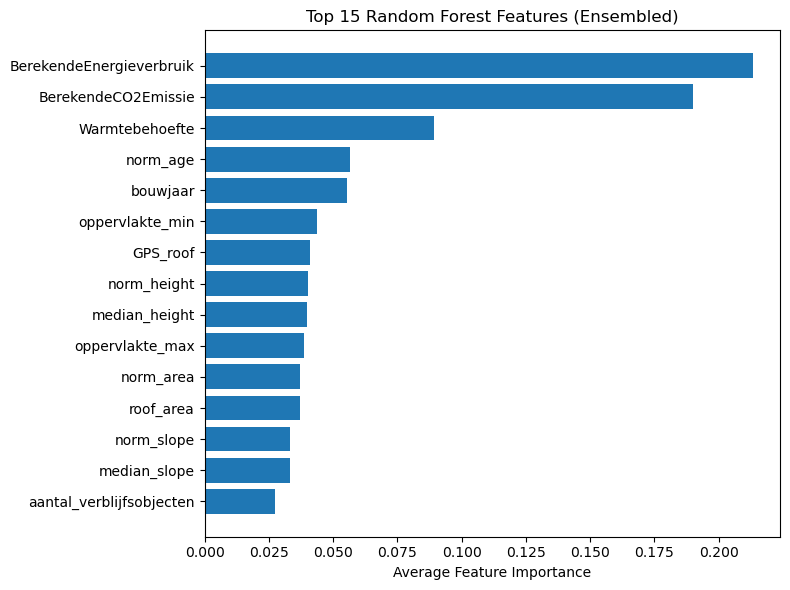

In [53]:
# Plot top N most important features
top_n = 15
top_df = importance_df.head(top_n).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_df['Feature'], top_df['Importance'])
plt.xlabel("Average Feature Importance")
plt.title(f"Top {top_n} Random Forest Features (Ensembled)")
plt.tight_layout()
plt.show()


partial dependence plot


Partial Dependence for Grouped Class 0


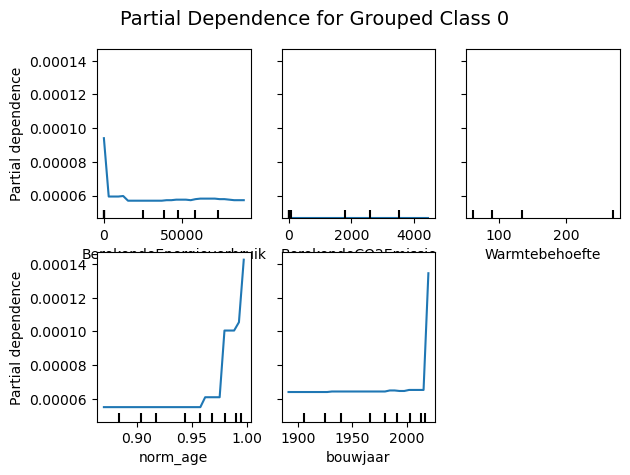


Partial Dependence for Grouped Class 1


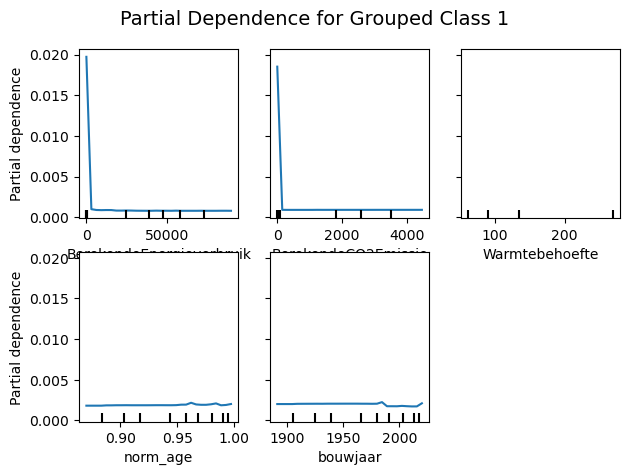


Partial Dependence for Grouped Class 2


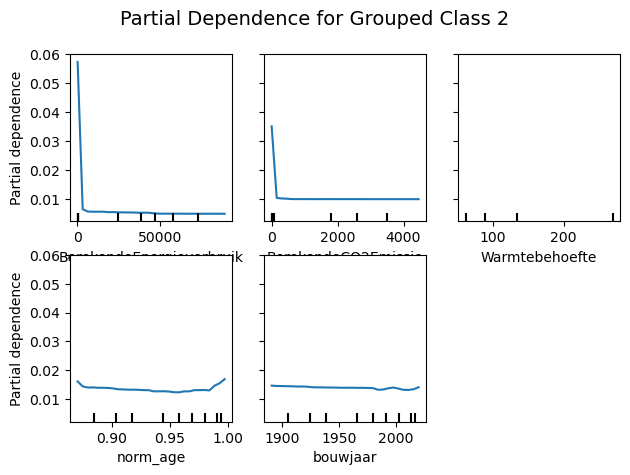

In [55]:
from sklearn.inspection import PartialDependenceDisplay

# Get top 5 features by importance
top_5_features = importance_df['Feature'].head(5).tolist()

# Use the raw input data (not preprocessed)
X_sampled = pd.concat([X_train, X_test], axis=0)

# Use one of the sub-estimators from the VotingClassifier (e.g. first model)
model_for_pdp = voting_ensemble.estimators_[0]

# Plot partial dependence for each of the 3 grouped labels
for class_label in [0, 1, 2]:
    print(f"\nPartial Dependence for Grouped Class {class_label}")

    PartialDependenceDisplay.from_estimator(
        model_for_pdp,
        X_sampled,
        features=top_5_features,
        kind="average",
        target=class_label,
        grid_resolution=30,
        n_jobs=-1  # Use all processors
    )

    plt.suptitle(f"Partial Dependence for Grouped Class {class_label}", fontsize=14)
    plt.tight_layout()
    plt.show()


COUNTERFACTUAL

***What would a green-roof building's energy label have been without the green roof?***

 Simulation of what label the RF thinks the building would have received without the green roof, based on its learned experience from buildings that actually don’t have green roofs, which is the RF above.

In [ ]:
# Load saved ensemble model
ensemble_model = joblib.load("10models/voting_ensemble.joblib")

# Prepare counterfactual test set
# Use the same green roof test set used during training
X_test_cf = X_test.copy()
X_test_cf['already_GR'] = 0  # Pretend they have no green roof

# Predict using ensemble
y_cf = ensemble_model.predict(X_test_cf)

# Convert to Series (optional, for labeling consistency)
y_test_series = pd.Series(y_test)
y_cf_series = pd.Series(y_cf)

# Apply grouping to compare grouped energy labels
y_test_grouped = y_test_series.map(group_label)
y_cf_grouped = y_cf_series.map(group_label)

# Print evaluation
print("\nCounterfactual (as if no green roof):")
print("Grouped Accuracy:", accuracy_score(y_test_grouped, y_cf_grouped))
print("Grouped F1 Score (macro):", f1_score(y_test_grouped, y_cf_grouped, average='macro'))
print("\nGrouped Classification Report:")
print(classification_report(y_test_grouped, y_cf_grouped))



Counterfactual (as if no green roof):
Grouped Accuracy: 0.8457611386138614
Grouped F1 Score (macro): 0.7224546800641877

Grouped Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.92      0.69       941
           1       0.94      0.86      0.90      5179
           2       0.78      0.45      0.57       344

    accuracy                           0.85      6464
   macro avg       0.76      0.74      0.72      6464
weighted avg       0.88      0.85      0.85      6464



In [60]:
# Compare shifts between original and counterfactual prediction
comparison_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_ensemble,
    'Counterfactual_Label': y_cf
})

# Calculate label shift (how many classes up or down)
comparison_df['Label_Change'] = comparison_df['Counterfactual_Label'] - comparison_df['Predicted_Label']

print("\nLabel Change Summary:")
print(comparison_df['Label_Change'].value_counts().sort_index())



Label Change Summary:
Label_Change
-2      42
-1     283
 0    5945
 1     166
 2      24
 3       2
 4       2
Name: count, dtype: int64


How to read the label change summary?
How many buildings would have received a better (negative in the scale), worse (positive in the scale), or same (zero) label without the green roof.
--> I would hope to see positve becuase it would mean that labels 

In [62]:
# Filter unchanged labels
unchanged_df = comparison_df[comparison_df['Label_Change'] == 0].copy()

# Join back primary_use_most_restrictive
unchanged_df = unchanged_df.join(
    gdf_labeled.loc[unchanged_df.index, ['primary_use_most_restrictive']]
)

# Define max label thresholds per building type
def at_best_label(row):
    if row['primary_use_most_restrictive'] == 'woning':
        return row['Predicted_Label'] <= 1  # A++++ or A+++++
    else:
        return row['Predicted_Label'] == 0  # Only A+++++

unchanged_df['Already_Best_Label'] = unchanged_df.apply(at_best_label, axis=1)

# Count how many of the unchanged were already best
best_count = unchanged_df['Already_Best_Label'].sum()
total_unchanged = len(unchanged_df)

print(f"Unchanged buildings: {total_unchanged}")
print(f"Of those, already at best possible label: {best_count}")

Unchanged buildings: 5945
Of those, already at best possible label: 0


**What if buildings that currently don’t have green roofs did get one — what would their new energy label be?**

In [64]:
# Set Save Directory
cf2_dir = "10models_cf2"
os.makedirs(cf2_dir, exist_ok=True)

In [65]:
# Setup column preprocessing 
categorical_cols = ['primary_use_most_restrictive']
full_cats = gdf_labeled['primary_use_most_restrictive'].dropna().unique()
full_cats_sorted = sorted(full_cats)

def build_pipeline(seed):
    encoder = OneHotEncoder(
        handle_unknown='ignore',
        categories=[full_cats_sorted],
        sparse_output=False
    )

    preprocessor = ColumnTransformer([
        ('num', KNNImputer(n_neighbors=5), [col for col in features_energy if col not in categorical_cols]),
        ('cat', encoder, categorical_cols)
    ])

    return Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', RandomForestClassifier(random_state=seed, class_weight='balanced'))
    ])

In [66]:
n_runs = 10
all_models_cf2 = []

# Fixed test set: all 6464 already_GR == 1
green_roof = gdf_labeled[gdf_labeled['already_GR'] == 1].copy()
X_green = green_roof[features_energy]
y_green = green_roof['EnergyLabel_ordinal']

for i in range(n_runs):
    # Sample 6464 from non-green roofs, stratified by EnergyLabel_ordinal
    sampled_no_green = (
        gdf_labeled[gdf_labeled['already_GR'] == 0]
        .groupby('EnergyLabel_ordinal', group_keys=False)
        .apply(lambda x: x.sample(frac=6464 / len(gdf_labeled[gdf_labeled['already_GR'] == 0]), random_state=100 + i))
        .reset_index(drop=True)
    )

    X_no_green = sampled_no_green[features_energy]
    y_no_green = sampled_no_green['EnergyLabel_ordinal']

    # Combine green and sampled no-green data
    X_combined = pd.concat([X_green, X_no_green], ignore_index=True).sample(frac=1.0, random_state=200 + i)
    y_combined = pd.concat([y_green, y_no_green], ignore_index=True)

    # Group labels into 3 classes for valid stratification
    y_grouped = y_combined.map(group_label)  # group_label must be defined as shown earlier

    # Split 80/20 using grouped labels for stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined,
        y_combined,  # still train with original 12-class labels
        test_size=0.2,
        stratify=y_grouped,
        random_state=300 + i
    )

    # Train model
    model = build_pipeline(seed=400 + i)
    model.fit(X_train, y_train)

    # Save model
    model_path = os.path.join(cf2_dir, f"cf2_model_run_{i}.joblib")
    joblib.dump(model, model_path)
    all_models_cf2.append(model)

In [67]:
# Create and save VotingClassifier 
voting_ensemble_cf2 = VotingClassifier(
    estimators=[(f'model_{i}', m) for i, m in enumerate(all_models_cf2)],
    voting='hard'
)

# You can fit to dummy data (required by VotingClassifier)
voting_ensemble_cf2.fit(X_train, y_train)

# Save the ensemble
ensemble_path = os.path.join(cf2_dir, "voting_ensemble_cf2.joblib")
joblib.dump(voting_ensemble_cf2, ensemble_path)

['10models_cf2/voting_ensemble_cf2.joblib']

In [68]:
# Load the ensemble model trained for Counterfactual 2
ensemble_model_cf2 = joblib.load("10models_cf2/voting_ensemble_cf2.joblib")

# Sample 6,464 non-green-roof buildings
subset_no_green = gdf_labeled[gdf_labeled['already_GR'] == 0].sample(n=6464, random_state=42).copy()

# Prepare input matrix (features only)
X_cf = subset_no_green[features_energy].copy()

# Predict baseline: without green roof
X_cf['already_GR'] = 0
baseline_preds = ensemble_model_cf2.predict(X_cf)

# Predict counterfactual: with green roof
X_cf['already_GR'] = 1
with_green_preds = ensemble_model_cf2.predict(X_cf)

In [69]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Baseline_Label': baseline_preds,
    'With_Green_Label': with_green_preds
})

# Label change magnitude 
comparison_df['Label_Change'] = comparison_df['With_Green_Label'] - comparison_df['Baseline_Label']

# Group labels
baseline_grouped = comparison_df['Baseline_Label'].map(group_label)
with_green_grouped = comparison_df['With_Green_Label'].map(group_label)

# Print metrics
print("\nGrouped Label Classification Report:")
print("Grouped Accuracy:", accuracy_score(baseline_grouped, with_green_grouped))
print("Grouped F1 Score (macro):", f1_score(baseline_grouped, with_green_grouped, average='macro'))
print("\n", classification_report(baseline_grouped, with_green_grouped))

# Print label change summary
print("\nLabel Change Summary:")
print(comparison_df['Label_Change'].value_counts().sort_index())



Grouped Label Classification Report:
Grouped Accuracy: 0.9927289603960396
Grouped F1 Score (macro): 0.9686100976859029

               precision    recall  f1-score   support

           0       0.98      0.94      0.96       231
           1       0.99      1.00      1.00      5931
           2       0.99      0.91      0.95       302

    accuracy                           0.99      6464
   macro avg       0.99      0.95      0.97      6464
weighted avg       0.99      0.99      0.99      6464


Label Change Summary:
Label_Change
-6       3
-5       3
-4       3
-3      20
-2      57
-1      37
 0    6295
 1      27
 2      16
 3       3
Name: count, dtype: int64


In [150]:
# Which baseline labels are most likely to change
label_change_counts = (
    comparison_df
    .assign(Changed=comparison_df['Label_Change'] != 0)
    .groupby('Baseline_Label')['Changed']
    .mean()
    .sort_values(ascending=False)
)
print(label_change_counts)

Baseline_Label
8     0.130137
7     0.127389
3     0.104478
10    0.076923
6     0.071287
11    0.052632
4     0.050000
9     0.025316
5     0.006660
1     0.000000
2     0.000000
Name: Changed, dtype: float64


In [152]:
# Add primary use info from the original dataset
comparison_df = comparison_df.join(
    gdf_labeled[['primary_use_most_restrictive']],
    how='left'
)

In [154]:
# Which primary use types are most likely to change?
primary_use_change = (
    comparison_df
    .assign(Changed=comparison_df['Label_Change'] != 0)
    .groupby('primary_use_most_restrictive')['Changed']
    .mean()
    .sort_values(ascending=False)
)
print(primary_use_change)

primary_use_most_restrictive
logies                                  0.153846
onderwijs                               0.050000
kantoor                                 0.036364
woning                                  0.026435
bijeenkomst zonder kinderdagverblijf    0.026217
winkel                                  0.012987
bijeenkomst met kinderdagverblijf       0.000000
zorg met bed                            0.000000
Name: Changed, dtype: float64


# RQ4 and RQ5

In [71]:
# Load CF2 ensemble model trained on both green and non-green roofs
ensemble_model_cf2 = joblib.load("10models_cf2/voting_ensemble_cf2.joblib")

# Select features from unlabeled data
X_unlabeled = gdf_unlabeled[features_energy].copy()

# Predict energy labels for all unlabeled rows (mixed GR and non-GR)
preds_unlabeled = ensemble_model_cf2.predict(X_unlabeled)
gdf_unlabeled['Predicted_EnergyLabel_ordinal'] = preds_unlabeled

# Convert back to categorical label
reverse_energy_order = {v: k for k, v in energy_order.items()}
gdf_unlabeled['Predicted_Energielabel'] = gdf_unlabeled['Predicted_EnergyLabel_ordinal'].map(reverse_energy_order)

In [72]:
gdf_unlabeled['Roof_insulation'] = gdf_unlabeled['Predicted_Energielabel'].apply(classify_roof_insulation)
gdf_unlabeled['primary_use_most_restrictive'] = gdf_unlabeled.apply(
    lambda row: get_most_restrictive_use(row['gebruiksdoel'], row['Predicted_Energielabel']),
    axis=1
)

In [73]:
def retrieve_mean_consumption_pred(row):
    building_type = row['primary_use_most_restrictive']
    label = row['Predicted_Energielabel']
    if pd.isna(building_type) or pd.isna(label):
        return np.nan
    key = (building_type.capitalize(), str(label).upper())
    return mean_consumption_lookup.get(key, np.nan)

gdf_unlabeled['Mean_Consumption_m2'] = gdf_unlabeled.apply(retrieve_mean_consumption_pred, axis=1)
gdf_unlabeled['EnergyLabel_ordinal'] = gdf_unlabeled['Predicted_EnergyLabel_ordinal']
gdf_unlabeled['Label_is_predicted'] = True

gdf_combined = pd.concat([gdf_labeled.assign(Label_is_predicted=False), gdf_unlabeled], ignore_index=True)

In [74]:
# Then make the duplicated splits for comparison
gdf_combined['Predicted_EnergyLabel_ordinal_8020'] = gdf_combined['Predicted_EnergyLabel_ordinal']
gdf_combined['Predicted_Energielabel_8020'] = gdf_combined['Predicted_EnergyLabel_ordinal_8020'].map(reverse_energy_order)

gdf_combined['Predicted_EnergyLabel_ordinal_6535'] = gdf_combined['Predicted_EnergyLabel_ordinal']
gdf_combined['Predicted_Energielabel_6535'] = gdf_combined['Predicted_EnergyLabel_ordinal_6535'].map(reverse_energy_order)

In [ ]:
# Load reduction values from included CSV
df2 = pd.read_csv('data/heating_coolig_reductions.csv')
df2['% Reduction'] = df2['% Reduction'].astype(str).str.replace('%', '').astype(float) / 100

reduction_dict = {}
for _, row in df2.iterrows():
    key = (row['Scenario'], row['Type'], row['Roof Type'])
    reduction_dict[key] = row['% Reduction']

# Estimate adjusted consumption
def estimate_retrofitted_consumption(row, roof_type):
    if pd.isna(row['Mean_Consumption_m2']):
        return np.nan
    insulation_status = 'Insulated' if row['Roof_insulation'] == 1 else 'Uninsulated'
    base_consumption = row['Mean_Consumption_m2']
    heating_share = 0.8
    cooling_share = 0.2
    heating_reduction = reduction_dict.get((insulation_status, 'Heating', roof_type), 0)
    cooling_reduction = reduction_dict.get((insulation_status, 'Cooling', roof_type), 0)
    adjusted = base_consumption * (
        heating_share * (1 - heating_reduction) +
        cooling_share * (1 - cooling_reduction)
    )
    return adjusted

In [76]:
def estimate_retrofitted_consumption_custom(row, roof_type, heating_share=0.65, cooling_share=0.35):
    if pd.isna(row['Mean_Consumption_m2']):
        return np.nan
    insulation_status = 'Insulated' if row['Roof_insulation'] == 1 else 'Uninsulated'
    base_consumption = row['Mean_Consumption_m2']
    heating_reduction = reduction_dict.get((insulation_status, 'Heating', roof_type), 0)
    cooling_reduction = reduction_dict.get((insulation_status, 'Cooling', roof_type), 0)
    adjusted = base_consumption * (
        heating_share * (1 - heating_reduction) +
        cooling_share * (1 - cooling_reduction)
    )
    return adjusted

In [77]:
# Apply adjustments for 80/20 and 65/35
gdf_combined['Adjusted_Consumption_Green'] = np.where(
    gdf_combined['already_GR'] != 1,
    gdf_combined.apply(lambda row: estimate_retrofitted_consumption(row, 'Green Roof'), axis=1),
    np.nan
)
gdf_combined['Adjusted_Consumption_DryGreen'] = np.where(
    gdf_combined['already_GR'] != 1,
    gdf_combined.apply(lambda row: estimate_retrofitted_consumption(row, 'Dry Green Roof'), axis=1),
    np.nan
)
gdf_combined['Adjusted_Consumption_Green_6535'] = np.where(
    gdf_combined['already_GR'] != 1,
    gdf_combined.apply(lambda row: estimate_retrofitted_consumption_custom(row, 'Green Roof', 0.65, 0.35), axis=1),
    np.nan
)
gdf_combined['Adjusted_Consumption_DryGreen_6535'] = np.where(
    gdf_combined['already_GR'] != 1,
    gdf_combined.apply(lambda row: estimate_retrofitted_consumption_custom(row, 'Dry Green Roof', 0.65, 0.35), axis=1),
    np.nan
)

In [78]:
# Create the label_ranges lookup table
label_ranges = long_df[['Building_Type', 'Label', 'Min_Consumption', 'Max_Consumption']].dropna()

In [79]:
# Convert to energy labels
def get_label_from_consumption(consumption, building_type):
    if pd.isna(consumption) or pd.isna(building_type):
        return np.nan
    building_type = building_type.capitalize()
    matching_rows = label_ranges[label_ranges['Building_Type'] == building_type]
    for _, row in matching_rows.iterrows():
        if row['Min_Consumption'] <= consumption <= row['Max_Consumption']:
            return row['Label']
    return np.nan

In [80]:
gdf_combined['EnergyLabel_Adjusted_Green'] = gdf_combined.apply(
    lambda row: get_label_from_consumption(row['Adjusted_Consumption_Green'], row['primary_use_most_restrictive']), axis=1)
gdf_combined['EnergyLabel_Adjusted_DryGreen'] = gdf_combined.apply(
    lambda row: get_label_from_consumption(row['Adjusted_Consumption_DryGreen'], row['primary_use_most_restrictive']), axis=1)
gdf_combined['EnergyLabel_Adjusted_Green_6535'] = gdf_combined.apply(
    lambda row: get_label_from_consumption(row['Adjusted_Consumption_Green_6535'], row['primary_use_most_restrictive']), axis=1)
gdf_combined['EnergyLabel_Adjusted_DryGreen_6535'] = gdf_combined.apply(
    lambda row: get_label_from_consumption(row['Adjusted_Consumption_DryGreen_6535'], row['primary_use_most_restrictive']), axis=1)

In [81]:
gdf_combined['Label_Before_8020'] = gdf_combined['Energielabel'].fillna(gdf_combined['Predicted_Energielabel_8020'])
gdf_combined['Label_Before_6535'] = gdf_combined['Energielabel'].fillna(gdf_combined['Predicted_Energielabel_6535'])

In [82]:
# Label to ordinal score mapping
label_order = ['A+++++', 'A++++', 'A+++', 'A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
label_to_score = {label: i + 1 for i, label in enumerate(label_order)}

# Before retrofit
gdf_combined['Score_Before_8020'] = gdf_combined['Label_Before_8020'].map(label_to_score)
gdf_combined['Score_Before_6535'] = gdf_combined['Label_Before_6535'].map(label_to_score)

# After retrofit - Green Roof
gdf_combined['Score_Adjusted_Green'] = gdf_combined['EnergyLabel_Adjusted_Green'].map(label_to_score)
gdf_combined['Score_Adjusted_Green_6535'] = gdf_combined['EnergyLabel_Adjusted_Green_6535'].map(label_to_score)

# After retrofit - Dry Green Roof
gdf_combined['Score_Adjusted_DryGreen'] = gdf_combined['EnergyLabel_Adjusted_DryGreen'].map(label_to_score)
gdf_combined['Score_Adjusted_DryGreen_6535'] = gdf_combined['EnergyLabel_Adjusted_DryGreen_6535'].map(label_to_score)

# Label shifts
gdf_combined['Label_Diff_Green'] = gdf_combined['Score_Before_8020'] - gdf_combined['Score_Adjusted_Green']
gdf_combined['Label_Diff_Green_6535'] = gdf_combined['Score_Before_6535'] - gdf_combined['Score_Adjusted_Green_6535']
gdf_combined['Label_Diff_DryGreen'] = gdf_combined['Score_Before_8020'] - gdf_combined['Score_Adjusted_DryGreen']
gdf_combined['Label_Diff_DryGreen_6535'] = gdf_combined['Score_Before_6535'] - gdf_combined['Score_Adjusted_DryGreen_6535']


Green Roof Retrofit Summary


,Total buildings,Improved (any),Stayed the same,Improved by 1,Improved by 2,Improved by 3+
Green Roof (80/20),452616,86557,366059,74407,12150,0
Green Roof (65/35),452616,86557,366059,74233,12324,0


Dry Green Roof Retrofit Summary


,Total buildings,Improved (any),Stayed the same,Improved by 1,Improved by 2,Improved by 3+
Dry Green Roof (80/20),452616,86557,366059,74480,12077,0
Dry Green Roof (65/35),452616,86557,366059,74233,12324,0


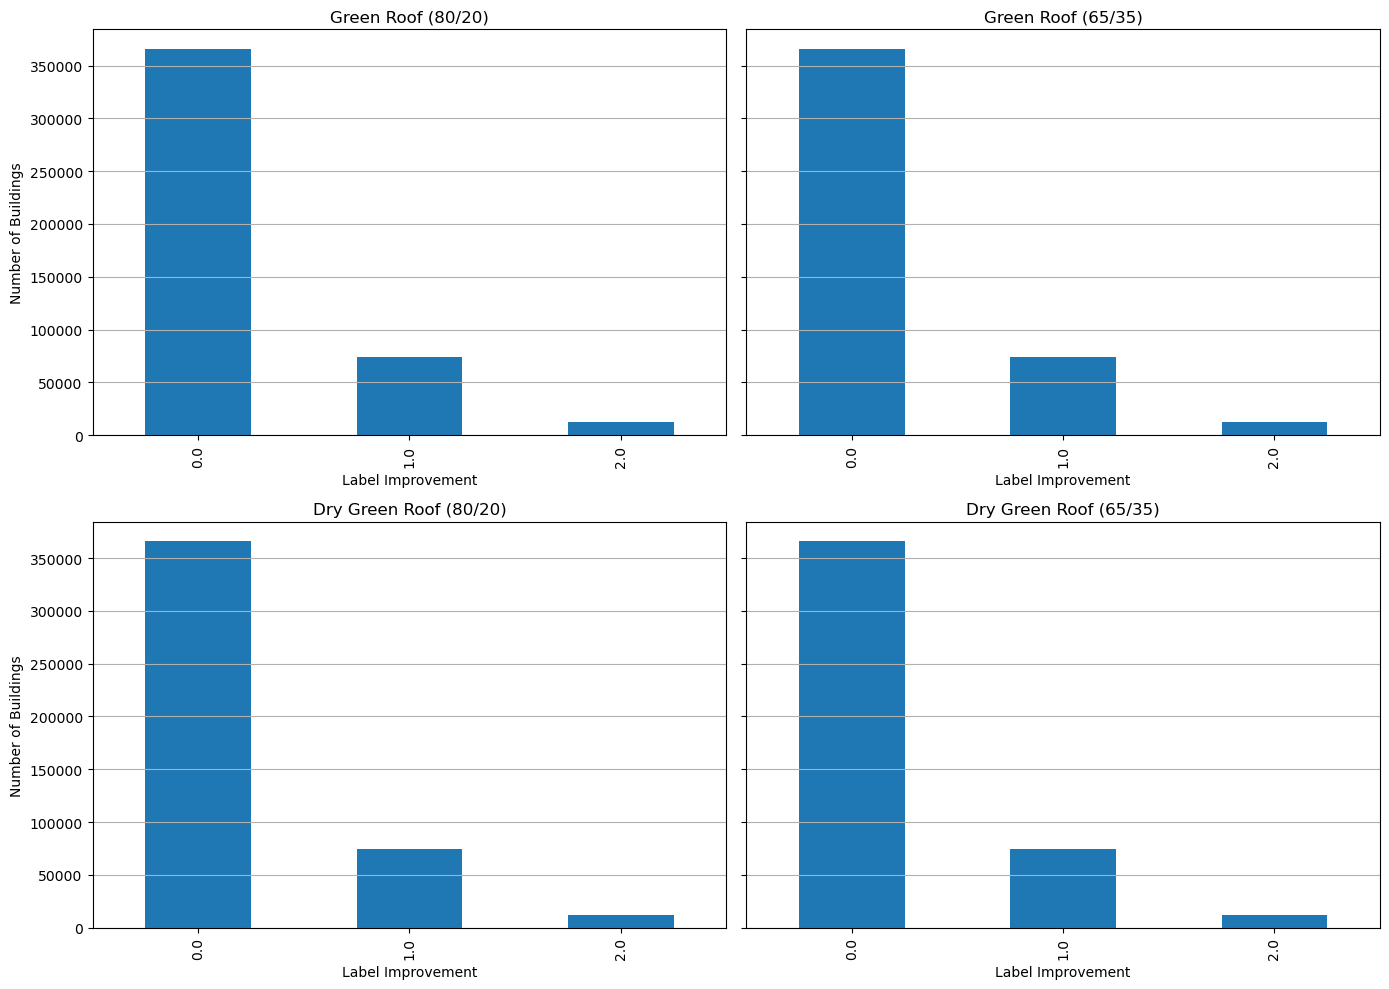

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_label_diff(series, label=""):
    summary = {
        "Total buildings": len(series.dropna()),
        "Improved (any)": (series > 0).sum(),
        "Stayed the same": (series == 0).sum(),
        "Improved by 1": (series == 1).sum(),
        "Improved by 2": (series == 2).sum(),
        "Improved by 3+": (series >= 3).sum(),
    }
    return pd.DataFrame(summary, index=[label])

# Summary tables
summary_8020_green = summarize_label_diff(gdf_combined['Label_Diff_Green'], label="Green Roof (80/20)")
summary_6535_green = summarize_label_diff(gdf_combined['Label_Diff_Green_6535'], label="Green Roof (65/35)")
summary_8020_dry   = summarize_label_diff(gdf_combined['Label_Diff_DryGreen'], label="Dry Green Roof (80/20)")
summary_6535_dry   = summarize_label_diff(gdf_combined['Label_Diff_DryGreen_6535'], label="Dry Green Roof (65/35)")

summary_table_green = pd.concat([summary_8020_green, summary_6535_green])
summary_table_dry   = pd.concat([summary_8020_dry, summary_6535_dry])

print("Green Roof Retrofit Summary")
display(summary_table_green)

print("Dry Green Roof Retrofit Summary")
display(summary_table_dry)

# Barplots for Label Diff Distribution 
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Green Roof
gdf_combined['Label_Diff_Green'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title("Green Roof (80/20)")
axes[0, 0].set_xlabel("Label Improvement")
axes[0, 0].set_ylabel("Number of Buildings")
axes[0, 0].grid(axis='y')

gdf_combined['Label_Diff_Green_6535'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title("Green Roof (65/35)")
axes[0, 1].set_xlabel("Label Improvement")
axes[0, 1].grid(axis='y')

# Dry Green Roof
gdf_combined['Label_Diff_DryGreen'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title("Dry Green Roof (80/20)")
axes[1, 0].set_xlabel("Label Improvement")
axes[1, 0].set_ylabel("Number of Buildings")
axes[1, 0].grid(axis='y')

gdf_combined['Label_Diff_DryGreen_6535'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Dry Green Roof (65/35)")
axes[1, 1].set_xlabel("Label Improvement")
axes[1, 1].grid(axis='y')

plt.tight_layout()
plt.show()


In [160]:
def summarize_improvements_by(df, diff_col, group_col):
    """Return absolute and relative value counts of improvements (>0) grouped by a given column."""
    improvements = df[df[diff_col] > 0]
    counts = improvements[group_col].value_counts()
    percentages = counts / counts.sum()
    return pd.DataFrame({'Count': counts, 'Percentage': percentages})

# Run summaries by label
label_improvements = {
    scenario: summarize_improvements_by(gdf_combined, diff_col, group_col)
    for scenario, (diff_col, group_col) in {
        'Green Roof (80/20)': ('Label_Diff_Green', 'Label_Before_8020'),
        'Green Roof (65/35)': ('Label_Diff_Green_6535', 'Label_Before_6535'),
        'Dry Green Roof (80/20)': ('Label_Diff_DryGreen', 'Label_Before_8020'),
        'Dry Green Roof (65/35)': ('Label_Diff_DryGreen_6535', 'Label_Before_6535'),
    }.items()
}

# Run summaries by primary use
use_improvements = {
    scenario: summarize_improvements_by(gdf_combined, diff_col, 'primary_use_most_restrictive')
    for scenario, diff_col in {
        'Green Roof (80/20)': 'Label_Diff_Green',
        'Green Roof (65/35)': 'Label_Diff_Green_6535',
        'Dry Green Roof (80/20)': 'Label_Diff_DryGreen',
        'Dry Green Roof (65/35)': 'Label_Diff_DryGreen_6535',
    }.items()
}

# Merge each scenario’s results into a single DataFrame for label and use
label_improvements_df = pd.concat(label_improvements, axis=1)
use_improvements_df = pd.concat(use_improvements, axis=1)

# Round percentages
label_improvements_df = label_improvements_df.round(4)
use_improvements_df = use_improvements_df.round(4)

# Display results
display(label_improvements_df)
display(use_improvements_df)


Green Roof (80/20)            Green Roof (65/35)             \
               Count Percentage              Count Percentage   
D              42920     0.4959              42920     0.4959   
E              21220     0.2452              21220     0.2452   
G              12011     0.1388              12011     0.1388   
F              10406     0.1202              10406     0.1202   

  Dry Green Roof (80/20)            Dry Green Roof (65/35)             
                   Count Percentage                  Count Percentage  
D                  42920     0.4959                  42920     0.4959  
E                  21220     0.2452                  21220     0.2452  
G                  12011     0.1388                  12011     0.1388  
F                  10406     0.1202                  10406     0.1202

Green Roof (80/20)             \
                                                  Count Percentage   
primary_use_most_restrictive                                         
woning                                            84759     0.9792   
kantoor                                             533     0.0062   
bijeenkomst zonder kinderdagverblijf                509     0.0059   
winkel                                              216     0.0025   
bijeenkomst met kinderdagverblijf                   216     0.0025   
onderwijs                                           120     0.0014   
logies                                               97     0.0011   
sport                                                52     0.0006   
zorg met bed                                         52     0.0006   
cel                                                   3     0.0000   

                                     Green Roof (65/35)             \
                                                  Count Percentage   
primary_use_most_restrictive                                         
woning                                            84759     0.9792   
kantoor                                             533     0.0062   
bijeenkomst zonder kinderdagverblijf                509     0.0059   
winkel                                              216     0.0025   
bijeenkomst met kinderdagverblijf                   216     0.0025   
onderwijs                                           120     0.0014   
logies                                               97     0.0011   
sport                                                52     0.0006   
zorg met bed                                         52     0.0006   
cel                                                   3     0.0000   

                                     Dry Green Roof (80/20)             \
                                                      Count Percentage   
primary_use_most_restrictive                                             
woning                                                84759     0.9792   
kantoor                                                 533     0.0062   
bijeenkomst zonder kinderdagverblijf                    509     0.0059   
winkel                                                  216     0.0025   
bijeenkomst met kinderdagverblijf                       216     0.0025   
onderwijs                                               120     0.0014   
logies                                                   97     0.0011   
sport                                                    52     0.0006   
zorg met bed                                             52     0.0006   
cel                                                       3     0.0000   

                                     Dry Green Roof (65/35)             
                                                      Count Percentage  
primary_use_most_restrictive                                            
woning                                                84759     0.9792  
kantoor                                                 533     0.0062  
bijeenkomst zonder kinderdagverblijf                    509     0.0059  
winkel                                                  216     0.0025  
bijeenkomst met kinderdagverblijf                       216     0.0025  
onderwijs                                               120     0.0014  
logies                                                   97     0.0011  
sport                                                    52     0.0006  
zorg met bed                                             52     0.0006  
cel                                                       3     0.0000